In [1]:
import numpy as np; import pandas as pd
# import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn; print(f"using torch version {torch.__version__}")
from torch import optim

#use numba's just-in-time compiler to speed things up
# from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; print('matplotlib version= ', mp.__version__)

import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
#reset matplotlib parameters to their defaults
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# LATEX
mp.rcParams.update({"text.usetex": True})
# plt.rcParams['text.usetex'] = True
mp.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]  # for \text command

# %matplotlib inline
import sys; import os
from IPython.display import Image, display
# from importlib import import_module
import plotly
try:
    import optuna
    print(f"using (optional) optuna version {optuna.__version__}")
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
import argparse
import time
# import sympy as sy

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

using torch version 1.11.0.post2
matplotlib version=  3.5.3


/tmp/ipykernel_2051203/4117212832.py:22: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mp.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]  # for \text command


using (optional) optuna version 3.0.0


In [2]:
# env = {}
# env.update(os.environ)
# env.update(source(os.environ["IQN_BASE"])) 

try:
    IQN_BASE = os.environ['IQN_BASE']
    print('BASE directoy properly set = ', IQN_BASE)
    utils_dir = os.path.join(IQN_BASE, 'utils/')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    from utils import *
    print('DATA directory also properly set, in %s' % os.environ['DATA_DIR'])
except Exception:
    # IQN_BASE=os.getcwd()
    print("""\nBASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path\n
    You can also do 
    os.environ['IQN_BASE']=<ABSOLUTE PATH FOR THE IQN REPO>
    or
    os.environ['IQN_BASE']=os.getcwd()""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
using torch version 1.11.0.post2
matplotlib version=  3.5.3
using (optional) optuna version 3.0.0
BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


In [3]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this:

In [4]:
################################### SET DATA CONFIGURATIONS ###################################
X       = ['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']

#set order of training:
#pT_first: pT->>m->eta->phi
#m_first: m->pT->eta->phi



#we'll just go with m first since that's the order we discuss in the paper.
ORDER='m_First'

if ORDER=='m_First':
    FIELDS  = {'RecoDatam' : {'inputs': X, 
                               'xlabel':  r'$m$ (GeV)', 
                              'ylabel':'$m^{reco}$',
                               'xmin': 0, 
                               'xmax': 25},
                           

               'RecoDatapT': {'inputs': X, 
                               'xlabel':  r'$p_T$ (GeV)' , 
                              'ylabel': '$p_T^{reco}$',
                               'xmin'  : 20, 
                               'xmax'  :  100},

               'RecoDataeta': {'inputs': X, 
                               'xlabel': r'$\eta$',
                               'ylabel':'$\eta^{reco}$',
                               'xmin'  : -5,
                               'xmax'  :  5},

               'RecoDataphi'  : {'inputs': X,
                               'xlabel': r'$\phi$' ,
                                'ylabel' :'$\phi^{reco}$',
                               'xmin'  : -3.2, 
                               'xmax'  :3.2}
              }
    
PARAMS_m = {
"n_layers": int(4),
"hidden_size": int(6),
"dropout_1": float(0.6),
"dropout_2": float(0.1),
"activation": "LeakyReLU",
    'optimizer_name':'NAdam',
    'starting_learning_rate':float(0.7),
    'momentum':float(0.6),
    'batch_size':int(1024),
    'n_iterations': int(2e6),
}

all_variable_cols = [
    "genDatapT",
    "genDataeta",
    "genDataphi",
    "genDatam",
    "RecoDatapT",
    "RecoDataeta",
    "RecoDataphi",
    "RecoDatam",
]
all_cols = [
    "genDatapT",
    "genDataeta",
    "genDataphi",
    "genDatam",
    "RecoDatapT",
    "RecoDataeta",
    "RecoDataphi",
    "RecoDatam",
    "tau",
]

In [5]:
from joblib import  Memory
DATA_DIR = os.environ["DATA_DIR"]
print(f"using DATA_DIR={DATA_DIR}")
# Define a directory on device to cache python functions. One of the best ways is using joblib's Memory module
# with @Memory.cache decorator on top of a function. This saves a huge amount of time, especially in functions
# that require a long time to execute, e.g. loading data.
memory = Memory(DATA_DIR)

print("USING NEW DATASET\n")
######################################
USE_BRADEN_SCALING=False
#####################################
################################### CONFIGURATIONS ###################################
@memory.cache
def load_raw_data():
    print(f'SUBSAMPLE = {SUBSAMPLE}')
    raw_train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )

    raw_test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )

    raw_valid_data=pd.read_csv(os.path.join(DATA_DIR,'validation_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )


    print('\n RAW TRAIN DATA SHAPE\n')
    print(raw_train_data.shape)
    print('\n RAW TRAIN DATA\n')
    raw_train_data.describe()#unscaled
    print('\n RAW TEST DATA\ SHAPEn')
    print(raw_test_data.shape)
    print('\n RAW TEST DATA\n')
    raw_test_data.describe()#unscaled

    return raw_train_data, raw_test_data, raw_valid_data

    
JUPYTER = False
use_subsample = True
# use_subsample = True
if use_subsample:
    SUBSAMPLE = int(
        1e5
    )  # subsample use for development - in production use whole dataset
else:
    SUBSAMPLE = None




########################################################################################
raw_train_data, raw_test_data, raw_valid_data =load_raw_data()

using DATA_DIR=/home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data
USING NEW DATASET



In [6]:
raw_train_data

,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
0,29.4452,0.828187,2.902130,2.85348,31.9132,0.817082,2.919510,2.59587,0.361310
1,24.3193,-1.163510,0.636469,5.83685,27.3513,-1.151020,0.652153,5.35538,0.126899
2,24.3193,-1.163510,0.636469,5.83685,27.3513,-1.151020,0.652153,5.35538,0.962307
3,24.3193,-1.163510,0.636469,5.83685,27.3513,-1.151020,0.652153,5.35538,0.457282
4,20.1703,1.844410,-0.186685,5.69090,24.2158,1.837910,-0.160621,4.59370,0.840862
...,...,...,...,...,...,...,...,...,...
99995,27.3537,-4.341310,2.264160,3.59567,30.2942,-4.349530,2.209270,3.42952,0.110503
99996,26.8630,4.460970,0.381944,6.05116,23.7580,4.521640,0.457971,4.20833,0.526119
99997,26.8630,4.460970,0.381944,6.05116,23.7580,4.521640,0.457971,4.20833,0.309711
99998,21.3142,4.150910,-2.812330,5.26289,21.9671,4.176750,-2.887050,4.14918,0.071362


In [7]:
def normal_split_t_x(df, target, input_features):
    """split dataframe into targets and feature arrays.

    Args:
        df (pandas.DataFrame): Dataframe of train, test or validation data.
        target (str): Choice of "RecoDatapT", "RecoDataeta", "RecoDataphi","RecoDatam" as target.
        input_features (list(str)): list of training features labels

    Returns:
    list(numpy.array): list of numpy array of target and training features
 """
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    # t = np.array(df[target])
    t = np.array(df[target])
    x = np.array(df[input_features])
    return t, x

In [8]:
target = "RecoDatapT"
source = FIELDS[target]
features = source["inputs"]
print("Training Features:\n", features)
print("\nTarget = ", target)

print("USING NEW DATASET\n")

Training Features:
 ['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']

Target =  RecoDatapT
USING NEW DATASET



In [9]:
print(f"spliting data for {target}")
train_t, train_x = normal_split_t_x(
df=raw_train_data, target=target, input_features=features
)
print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
print("\n Training features:\n")
print(train_x)
valid_t, valid_x = normal_split_t_x(
df=raw_valid_data, target=target, input_features=features
)
print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
test_t, test_x = normal_split_t_x(df=raw_test_data, target=target, input_features=features)
print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)


print("no need to train_test_split since we already have the split dataframes")
print(valid_x.mean(axis=0), valid_x.std(axis=0))
print(train_x.mean(axis=0), train_x.std(axis=0))
print(valid_t.mean(), valid_t.std())
print(train_t.mean(), train_t.std())
NFEATURES = train_x.shape[1]
######################################################

spliting data for RecoDatapT
train_t shape =  (100000,) train_x shape =  (100000, 4)

 Training features:

[[31.9132    0.817082  2.91951   2.59587 ]
 [27.3513   -1.15102   0.652153  5.35538 ]
 [27.3513   -1.15102   0.652153  5.35538 ]
 ...
 [23.758     4.52164   0.457971  4.20833 ]
 [21.9671    4.17675  -2.88705   4.14918 ]
 [44.5515    2.0938   -0.389151  6.66738 ]]
valid_t shape =  (100000,) valid_x shape =  (100000, 4)
test_t shape =  (100000,) test_x shape =  (100000, 4)
no need to train_test_split since we already have the split dataframes
[ 3.28693884e+01 -1.94726970e-03 -1.08829962e-02  5.56171091e+00] [15.57324857  2.19476169  1.81196705  2.6282735 ]
[3.29671688e+01 2.21612240e-03 7.27381886e-03 5.56540206e+00] [15.77965621  2.21042978  1.80959243  2.68547229]
32.869388404 15.573248566394462
32.967168834000006 15.77965621193832


In [10]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from
    # the range [0, length-1] corresponding to the
    # row indices.
    rows = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

## train

In [11]:
num_layers = 10
N_FEATURES=train_x.shape[1]
base_dist = StandardNormal(shape=[N_FEATURES])
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=N_FEATURES))
    transforms.append(MaskedAffineAutoregressiveTransform(features=N_FEATURES, 
                                                          hidden_features=4))
    
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [12]:
def train_flow(n_iterations):
    for i in range(n_iterations):
        batch_x, batch_t = get_batch(train_x, train_t, 58)
        x = torch.tensor(batch_x, dtype=torch.float32)
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs = x).mean()
        loss.backward()
        optimizer.step()


In [13]:
train_flow(5000)

In [14]:
test_x.shape

(100000, 4)

In [15]:
def evaluate_flow():
    test_X=torch.tensor(test_x, dtype=torch.float32)
    likelihood  = flow.log_prob(test_X).exp()
    return likelihood

In [16]:
likelihood = evaluate_flow()

In [17]:
likelihood.shape

torch.Size([100000])

In [19]:
samples = flow.sample(test_x.shape[0]).detach().numpy()
samples

array([[25.142113  , -3.3062284 , -0.49941838,  6.0706935 ],
       [54.25011   , -1.6250437 , -2.0517218 ,  8.605469  ],
       [34.54987   , -1.2403871 ,  0.6491311 ,  6.8237805 ],
       ...,
       [33.811314  ,  2.12686   , -1.2807467 ,  6.374767  ],
       [22.655596  ,  0.8908781 ,  2.1754103 ,  4.3618817 ],
       [33.555767  , -0.35557398, -0.30414277,  2.9271367 ]],
      dtype=float32)

# Plot

In [20]:

def get_hist_simple(predicted_dist, target):
    
    range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
    bins=50
    predicted_label_counts, label_edges = np.histogram(
        predicted_dist, range=range_, bins=bins
    )
    
    REAL_DIST = raw_test_data[target]
    real_label_counts, _ = np.histogram(REAL_DIST, range=range_, bins=bins)
    label_edges = label_edges[1:] / 2 + label_edges[:-1] / 2
    return real_label_counts, predicted_label_counts, label_edges

In [21]:
raw_test_data[target]

0        44.3274
1        44.3274
2        27.4750
3        33.8797
4        23.3141
          ...   
99995    30.4103
99996    30.1372
99997    30.1372
99998    21.2735
99999    27.0770
Name: RecoDatapT, Length: 100000, dtype: float64

In [22]:
def plot_one(
    target, real_edges, real_counts, predicted_counts, save_plot=False, PARAMS=None, JUPYTER=True
):
    norm_data = raw_test_data.shape[0]
    norm_predicted = samples.shape[0]
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(3.5 * 3 / 2.5, 3.8), gridspec_kw={"height_ratios": [2, 0.5]}
    )
    ax1.step(
        real_edges, real_counts / norm_data, where="mid", color="k", linewidth=0.5
    )  # step real_count_pt
    
    ax1.step(
        real_edges,
        predicted_counts / norm_predicted,
        where="mid",
        color="#D7301F",
        linewidth=0.5,
    )  # step predicted_count_pt
    ax1.scatter(
        real_edges,
        real_counts / norm_data,
        label="reco",
        color="k",
        facecolors="none",
        marker="o",
        s=5,
        linewidth=0.5,
    )
    ax1.scatter(
        real_edges,
        predicted_counts / norm_predicted,
        label="flow",
        color="#D7301F",
        marker="x",
        s=5,
        linewidth=0.5,
    )
    ax1.set_xlim(range_)
    ax1.set_ylim(0, max(predicted_counts / norm_predicted) * 1.1)
    ax1.set_ylabel("counts")
    ax1.set_xticklabels([])
    ax1.legend(loc="upper right")

    ratio = (predicted_counts / norm_predicted) / (real_counts / norm_data)
    ax2.scatter(
        real_edges, ratio, color="r", marker="x", s=5, linewidth=0.5
    )  # PREDICTED (IQN)/Reco (Data)
    ax2.scatter(
        real_edges,
        ratio / ratio,
        color="k",
        marker="o",
        facecolors="none",
        s=5,
        linewidth=0.5,
    )
    ax2.set_xlim(range_)
    ax2.set_xlabel(FIELDS[target]["xlabel"])
    ax2.set_ylabel(
        r"$\frac{\textnormal{predicted}}{\textnormal{reco}}$"
        #    , fontsize=10
    )
    ax2.set_ylim((YLIM))
    ax2.set_xlim(range_)
    ax2.set_yticklabels([0.8, 1.0, 1.2])
    if JUPYTER==True:
        plt.show()
    else:
        plt.tight_layout()
        fig.subplots_adjust(wspace=0.5, hspace=0.2)
        fig.subplots_adjust(wspace=0.0, hspace=0.1)
        plt.axis('off')

    # plt.gca().set_position([0, 0, 1, 1])
    if save_plot:
        plot_filename = utils.get_model_filename(target, PARAMS).split(".dict")[0] + ".png"
        plt.savefig(
            os.path.join(IQN_BASE, "JupyterBook", "Cluster", "EVALUATE", plot_filename)
        )

    
    # fig.show()
    # plt.show();
    # plt.axis("off")
    # plt.gca().set_position([0, 0, 1, 1])


## $p_T$

In [23]:
target = 'RecoDatapT'
range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
bins = 50

YLIM = (0.8, 1.2)

real_label_counts_pT, predicted_label_counts_pT, label_edges_pT = get_hist_simple(
    predicted_dist=samples[:,0], target=target
)

/tmp/ipykernel_2051203/2958219677.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0.8, 1.0, 1.2])


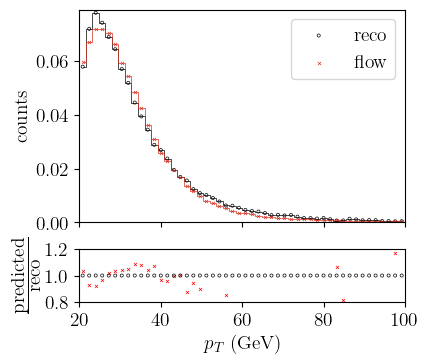

In [24]:
plot_one(
    target=target,
    real_edges=label_edges_pT,
    real_counts=real_label_counts_pT,
    predicted_counts=predicted_label_counts_pT,
    save_plot=False,
    PARAMS=PARAMS_m
)

## $\eta$

In [26]:
target = 'RecoDataeta'
range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
bins = 50

YLIM = (0.8, 1.2)

real_label_counts_eta, predicted_label_counts_eta, label_edges_eta = get_hist_simple(
    predicted_dist=samples[:,1], target=target
)

/tmp/ipykernel_2051203/2958219677.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0.8, 1.0, 1.2])


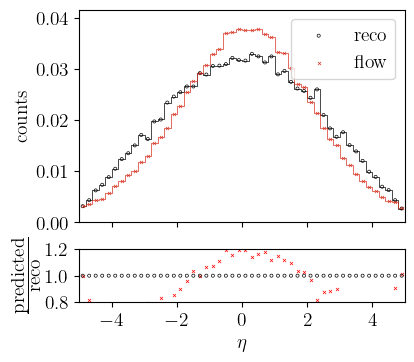

In [27]:
plot_one(
    target=target,
    real_edges=label_edges_eta,
    real_counts=real_label_counts_eta,
    predicted_counts=predicted_label_counts_eta,
    save_plot=False,
    PARAMS=PARAMS_m
)

## $\phi$

In [28]:
target = 'RecoDataphi'
range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
bins = 50

YLIM = (0.8, 1.2)

real_label_counts_phi, predicted_label_counts_phi, label_edges_phi = get_hist_simple(
    predicted_dist=samples[:,2], target=target
)

/tmp/ipykernel_2051203/2958219677.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0.8, 1.0, 1.2])


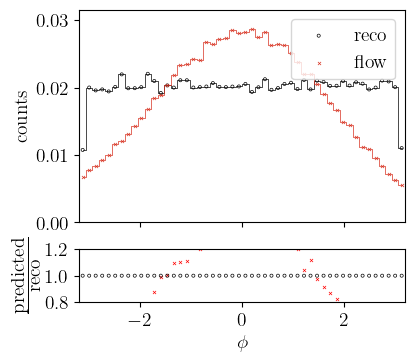

In [29]:
plot_one(
    target=target,
    real_edges=label_edges_phi,
    real_counts=real_label_counts_phi,
    predicted_counts=predicted_label_counts_phi,
    save_plot=False,
    PARAMS=PARAMS_m
)

## $m$

In [30]:
target = 'RecoDatam'
range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
bins = 50

YLIM = (0.8, 1.2)

real_label_counts_m, predicted_label_counts_m, label_edges_m = get_hist_simple(
    predicted_dist=samples[:,3], target=target
)

/tmp/ipykernel_2051203/2958219677.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0.8, 1.0, 1.2])


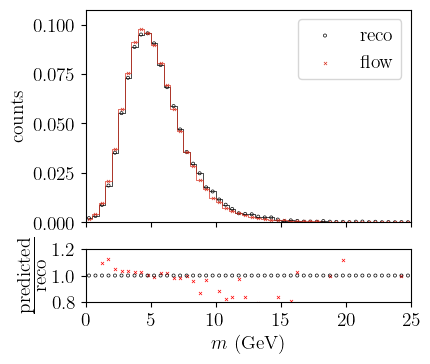

In [31]:
plot_one(
    target=target,
    real_edges=label_edges_m,
    real_counts=real_label_counts_m,
    predicted_counts=predicted_label_counts_m,
    save_plot=False,
    PARAMS=PARAMS_m
)